In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler,OneHotEncoder
from sklearn.feature_selection import mutual_info_regression

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


In [14]:
home_data = pd.read_csv("../input/home-data-for-ml-course/train.csv",index_col = "Id")
pd.options.display.max_columns = None
pd.options.display.max_rows = None

test_data = pd.read_csv("../input/home-data-for-ml-course/test.csv",index_col = "Id")
home_data.head()

train_data = home_data[home_data.columns[0:-1]]
y = home_data.SalePrice


obj_cols = [
    f for f in train_data.columns if (train_data[f].dtype == 'object')
]



MSSubClass        0.000000
MSZoning          0.000000
LotFrontage      17.739726
LotArea           0.000000
Street            0.000000
Alley            93.767123
LotShape          0.000000
LandContour       0.000000
Utilities         0.000000
LotConfig         0.000000
LandSlope         0.000000
Neighborhood      0.000000
Condition1        0.000000
Condition2        0.000000
BldgType          0.000000
HouseStyle        0.000000
OverallQual       0.000000
OverallCond       0.000000
YearBuilt         0.000000
YearRemodAdd      0.000000
RoofStyle         0.000000
RoofMatl          0.000000
Exterior1st       0.000000
Exterior2nd       0.000000
MasVnrType        0.547945
MasVnrArea        0.547945
ExterQual         0.000000
ExterCond         0.000000
Foundation        0.000000
BsmtQual          2.534247
BsmtCond          2.534247
BsmtExposure      2.602740
BsmtFinType1      2.534247
BsmtFinSF1        0.000000
BsmtFinType2      2.602740
BsmtFinSF2        0.000000
BsmtUnfSF         0.000000
T

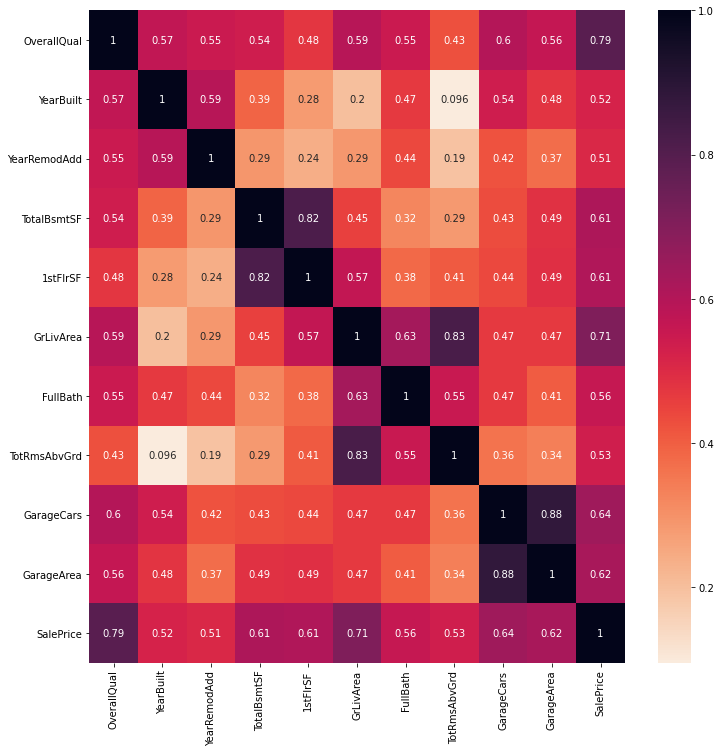

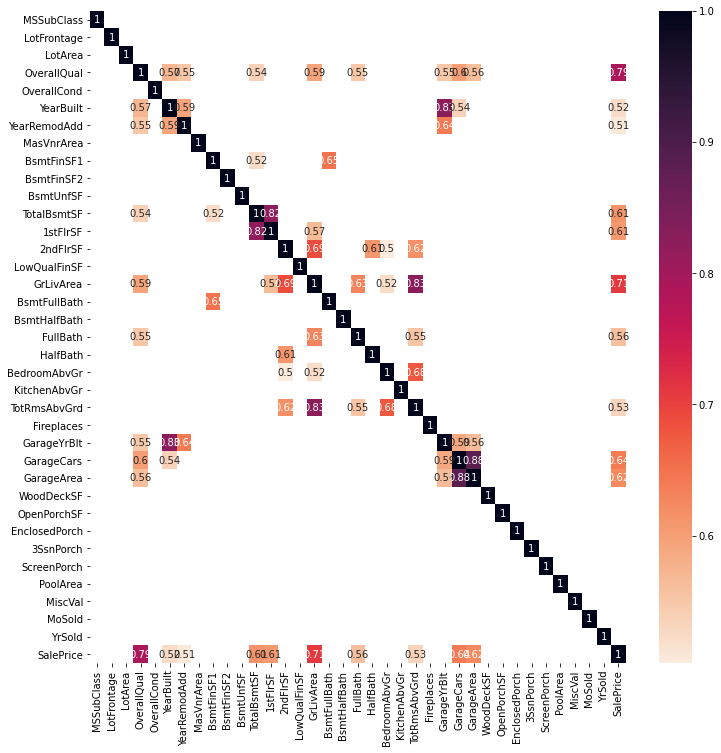

In [15]:
X_corr = train_data.copy()
X_corr['SalePrice'] = home_data.SalePrice

#Get Absolute correlation
X_corr = X_corr.corr()
X_corr = X_corr.applymap(lambda x: x*-1 if x<0 else x)


#Print heatmap for features having absolute correlation > 0.5 with SalePrice
corr_features = X_corr[X_corr['SalePrice']>0.5]["SalePrice"].index
X_corr_features = train_data.copy()
X_corr_features['SalePrice'] = home_data.SalePrice
X_corr_features = X_corr_features[corr_features].corr().applymap(lambda x: x*-1 if x<0 else x)
plt.subplots(figsize=(12,12))
sns.heatmap(X_corr_features,annot=True,cmap = sns.cm.rocket_r)

#Print heatmap for features having absolute correlation > 0.5 with each other
plt.subplots(figsize=(12,12))
sns.heatmap(X_corr,annot=True,cmap = sns.cm.rocket_r,mask = X_corr < 0.5)

#Missing value analysis
missing_values = home_data.isnull().sum()*100/len(home_data)
print(missing_values)


In [16]:
#Analysis: 4 pairs of inter co-related features identified, one of each to be removed
#Missing values mostly because of the absence of house_feature, which will be treated as 'None'
#Feaures co-related with SalePrice will be used for further feature engineering (Log transform, squares, cubes,etc)


#Store features according to their type

na_cols=["Alley","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","FireplaceQu","GarageType","GarageFinish","GarageQual","GarageCond","PoolQC","Fence","MiscFeature","MasVnrType"]
num_cols = [
    f for f in train_data.columns if ((train_data[f].dtype == 'float64')|(train_data[f].dtype == 'int64'))
]
ord_cols = ["LotShape", "LandSlope", "HouseStyle", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond","BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", "KitchenQual", "Functional", "FireplaceQu", "GarageFinish", "GarageQual","GarageCond","PavedDrive","PoolQC","Fence","SaleType","SaleCondition","Alley"]
car_cols = ["MSZoning","Street","LandContour","Utilities","LotConfig","Neighborhood","Condition1","Condition2","BldgType","RoofStyle","RoofMatl",
"Exterior1st","Exterior2nd","MasVnrType","Foundation","Heating","CentralAir","Electrical","GarageType","MiscFeature"]








In [17]:
#Missing value and other adjustments
def col_transform(X,ord_cols,car_cols,num_cols,na_cols):
    year_features = ['YearBuilt', 'YearRemodAdd', 'YrSold','GarageYrBlt'] 
    for f in year_features:
        X[f] = 2021 - X[f]
    for f in na_cols: 
        X[f].fillna("None",inplace=True)

    X.Electrical.fillna(X.Electrical.mode()[0],inplace=True)
    X.MasVnrArea.fillna(0,inplace=True)
    X.LotFrontage = X.LotFrontage.fillna(X.groupby(['Neighborhood']).LotFrontage.transform('mean'))
    X.drop(["1stFlrSF","TotRmsAbvGrd","GarageArea","GarageYrBlt"],axis=1,inplace=True)
    return X

#Label Encoding and One Hot Encoding
def encode(X,oh,le_dict):
    for col in ord_cols:
        X[col] = le_dict.get(col).transform(X[col])
    OH_cols = pd.DataFrame(oh.transform(X[car_cols]))
    OH_cols.index = X.index
    X = X.drop(car_cols,axis=1)
    X = pd.concat([X,OH_cols],axis=1)
    return X

#Feature Engineering
def feature_add(X):
    X["OverallQual_2"] = X["OverallQual"]**2
    X["OverallQual_3"] = X["OverallQual"]**3
    X["OverallQual_sqrt"] = np.sqrt(X["OverallQual"].astype(int))

    X["ExterQual_2"] = X["ExterQual"]**2
    X["ExterQual_3"] = X["ExterQual"]**3

    X["GrLivArea_2"] = X["GrLivArea"]**2
    X["GrLivArea_3"] = X["GrLivArea"]**3

    X["GarageCars_2"] = X["GarageCars"]**2
    X["GarageCars_3"] = X["GarageCars"]**3

    X["GrLivArea_sqrt"] = np.sqrt(X["GrLivArea"])
    X['GrLivArea_log'] = np.log1p(X['GrLivArea'])

    X["TotalBsmtSF_2"] = X["TotalBsmtSF"] ** 2
    X["TotalBsmtSF_3"] = X["TotalBsmtSF"] ** 3
    X["TotalBsmtSF_sqrt"] = np.sqrt(X["TotalBsmtSF"])

    X['HasBsmt'] = np.where(X['TotalBsmtSF']>0, 1, 0)
    X['GarageCars_log'] = np.log1p(X['GarageCars'])

    X['TotalHomeQual'] = X['OverallQual'] + X['OverallCond']
    return X


In [18]:
#Data after missing value adjustments
to_encode_train_X = col_transform(train_data,ord_cols,car_cols,num_cols,na_cols)
to_encode_test_X = col_transform(test_data,ord_cols,car_cols,num_cols,na_cols)

#Label Encoding dictionary to store LabelEncoder() instance for each column
le_dict = {}
le_data = pd.concat([to_encode_train_X[ord_cols],to_encode_test_X[ord_cols]],axis=0) #Combine train and test for fitting LabelEncoder
for col in ord_cols:
    le = LabelEncoder()
    le.fit(le_data[col])
    le_dict[col]=le

oh = OneHotEncoder(handle_unknown='ignore', sparse=False)    
oh.fit(to_encode_train_X[car_cols])

fe_train_X = encode(to_encode_train_X,oh,le_dict)
fe_test_X = encode(to_encode_test_X,oh,le_dict)

train_X = feature_add(fe_train_X)
test_X = feature_add(fe_test_X)



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [21]:
#Try different Models     
model_text = ["RFR", "XGB", "LR", "DT"]
RFR = RandomForestRegressor(random_state=1)
XGB = XGBRegressor(n_estimators=1000,learning_rate=0.01)
LR = LinearRegression()
DT = DecisionTreeRegressor(max_leaf_nodes=50)

models = [RFR,XGB,LR,DT]
scores = []

for m in models:
    score = -1*cross_val_score(m,train_X,y,cv=5,scoring="neg_mean_absolute_error").mean()
    scores.append(score)

scores_series = pd.Series(scores,index=model_text)
scores_series



RFR    17495.088466
XGB    16220.468785
LR     19791.640373
DT     25280.039968
dtype: float64

In [22]:
#Selecting the preferred model
XGB = XGBRegressor(n_estimators=1000,learning_rate=0.01)
XGB.fit(train_X,y)
predictions = XGB.predict(test_X)

In [159]:
output = pd.DataFrame({'Id':test_data.index,'SalePrice':predictions})
output.to_csv('submission.csv',index=False)
